## Code to analyze FS output

1. DKT CT distributions 
2. ASEG vol distribution


In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib


In [2]:
ds_name = "METAL"

data_dir = f"/home/nikhil/projects/Parkinsons/nimhans/data/PD_{ds_name}/"  
session = "ses-01"
tabular_dir = f"{data_dir}/tabular/"

# manifest
manifest_csv = f"{tabular_dir}/manifest.csv"

# demographics
demographics_csv = f"{tabular_dir}/demographics/demographics.csv"

# id_mapping
id_mapping_csv = f"{data_dir}/scratch/participant_id_bids_id_map.csv"

# imaging derivatives
FS_dir = f"{data_dir}/derivatives/freesurfer/v7.3.2/"
FS_DKT_dir = f"{FS_dir}/extractions/{session}/"

DKT_csv = f"{FS_DKT_dir}/aparc.csv"
ASEG_csv = f"{FS_DKT_dir}/aseg.csv"

# UKB encoding of FS fields (DKT + asg)
region_field_dir = "../region_field_ids"
ukbb_dkt_ct_fields = f"{region_field_dir}/UKBB_DKT_CT_Fields.csv"
ukbb_aseg_vol_fields = f"{region_field_dir}/UKBB_ASEG_vol_Fields.csv"

# save dirs
analysis_dir = f"/home/nikhil/projects/Parkinsons/neuro_arch/analysis" 
agg_data_dir = f"{analysis_dir}/derived_data/nimhans_{ds_name.lower()}"

results_dir = f"{agg_data_dir}/agg_dfs/"
figs_dir = f"{agg_data_dir}/figs/"

### Colormaps

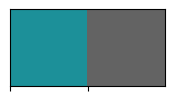

In [3]:
from enum import Enum
class my_colors(Enum):
    CONTROL = "#636363"
    PD = "#1c9099"
    
color_list = [my_colors.PD.value, my_colors.CONTROL.value,]
palette = sns.color_palette(palette=color_list) #sns.husl_palette()

sns.palplot(palette)

### manifest

In [4]:
manifest_cols = ["participant_id", "visit", "session"]

manifest_df = pd.read_csv(manifest_csv)
manifest_df = manifest_df[manifest_cols]

manifest_participants = manifest_df["participant_id"].unique()
n_manifest_participants = len(manifest_participants)
print(f"manifest participants: {n_manifest_participants}")
manifest_df.head()

manifest participants: 132


,participant_id,visit,session
0,MPD_HC_T1_01,V01,ses-01
1,MPD_HC_T1_02,V01,ses-01
2,MPD_HC_T1_03,V01,ses-01
3,MPD_HC_T1_04,V01,ses-01
4,MPD_HC_T1_05,V01,ses-01


### Demographic data

In [5]:
demographics_df = pd.read_csv(demographics_csv)
participants = demographics_df["participant_id"].unique()
n_participants = len(participants)
print(f"n_participants: {n_participants}")
group_counts = demographics_df.groupby(["group"]).count()
print(f"group counts: {group_counts}")
demographics_df.head()

n_participants: 132
group counts:          participant_id  visit  age  sex
group                                   
PD                   67     67   60   60
control              65     65   65   65


,participant_id,visit,group,age,sex
0,MPD_HC_T1_01,V01,control,50.0,M
1,MPD_HC_T1_02,V01,control,40.0,F
2,MPD_HC_T1_03,V01,control,38.0,F
3,MPD_HC_T1_04,V01,control,60.0,M
4,MPD_HC_T1_05,V01,control,42.0,F


### Merge demographics and manifest

In [6]:
demographics_df = pd.merge(demographics_df, manifest_df, on=["participant_id", "visit"])

#---------------------------------------------
## METAL specific
id_mapping_df = pd.read_csv(id_mapping_csv)
demographics_df = pd.merge(demographics_df, id_mapping_df[["participant_id","bids_id"]], on=["participant_id"])
#---------------------------------------------

demographics_df.head()

,participant_id,visit,group,age,sex,session,bids_id
0,MPD_HC_T1_01,V01,control,50.0,M,ses-01,sub-METALHC001
1,MPD_HC_T1_02,V01,control,40.0,F,ses-01,sub-METALHC002
2,MPD_HC_T1_03,V01,control,38.0,F,ses-01,sub-METALHC003
3,MPD_HC_T1_04,V01,control,60.0,M,ses-01,sub-METALHC004
4,MPD_HC_T1_05,V01,control,42.0,F,ses-01,sub-METALHC005


### Filter demographics based on available BIDS data

In [7]:
bids_ids = demographics_df["bids_id"].unique()
demographics_df = demographics_df[demographics_df["bids_id"].isin(bids_ids)]
demographics_df.head()

NameError: name 'bids_ids' is not defined

### Read DKT data

In [ ]:
DKT_ROIs = ['caudalanteriorcingulate', 'caudalmiddlefrontal','cuneus', 'entorhinal', 'fusiform', 'inferiorparietal',
       'inferiortemporal', 'isthmuscingulate', 'lateraloccipital','lateralorbitofrontal', 'lingual', 'medialorbitofrontal',
       'middletemporal', 'parahippocampal', 'paracentral', 'parsopercularis', 'parsorbitalis', 'parstriangularis',
       'pericalcarine', 'postcentral', 'posteriorcingulate', 'precentral', 'precuneus', 'rostralanteriorcingulate',
       'rostralmiddlefrontal', 'superiorfrontal', 'superiorparietal', 'superiortemporal', 'supramarginal', 'transversetemporal',
       'insula']

lh_DKT_ROIs_dict = dict(zip(list("lh." + pd.Series(DKT_ROIs)), DKT_ROIs))
rh_DKT_ROIs_dict = dict(zip(list("rh." + pd.Series(DKT_ROIs)), DKT_ROIs))

In [ ]:
CT_DKT_df = pd.read_csv(DKT_csv)
CT_DKT_df = CT_DKT_df.rename(columns={"participant_id":"bids_id"})

bids_ids = CT_DKT_df["bids_id"].unique()
print(f"n_bids: {len(bids_ids)}")

# Merge with demographics
CT_DKT_df = pd.merge(CT_DKT_df,demographics_df,on="bids_id",how="left")
CT_DKT_df.head()

### Split DKT data into left and right hemisphere

In [ ]:
save_results = False

demo_cols = ["participant_id","bids_id", "age","sex","group"]

lh_CT_DKT_df = CT_DKT_df[demo_cols + list(lh_DKT_ROIs_dict.keys())].copy()
rh_CT_DKT_df = CT_DKT_df[demo_cols + list(rh_DKT_ROIs_dict.keys())].copy()

lh_CT_DKT_df = lh_CT_DKT_df.rename(columns=lh_DKT_ROIs_dict)
lh_CT_DKT_df["hemi"] = "lh"
rh_CT_DKT_df = rh_CT_DKT_df.rename(columns=rh_DKT_ROIs_dict)
rh_CT_DKT_df["hemi"] = "rh"

CT_DKT_df = pd.concat([lh_CT_DKT_df,rh_CT_DKT_df], axis=0)

if save_results:
    CT_DKT_df.to_csv(f"{results_dir}/CT_DKT_df.csv")

CT_DKT_df.head()

### Plot DKT

In [ ]:
save_fig = False

CT_DKT_df_melt = CT_DKT_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="CT")

plot_df = CT_DKT_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)

sns.set(font_scale=3)
plot_kind = "box" # "violin", "boxen", "point", "bar", or “strip”
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="ROI",x="CT", hue="group", col="hemi",kind=plot_kind,palette=palette, data=plot_df, aspect=0.5, height=20)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/DKT.png")

### Volumetric measures

In [ ]:
vol_ASEG_df = pd.read_csv(ASEG_csv)
vol_ASEG_df = vol_ASEG_df.rename(columns={"participant_id":"bids_id"})

bids_ids = list(vol_ASEG_df["bids_id"])
print(f"n_bids: {len(bids_ids)}")

# Merge with demographics info
vol_ASEG_df = pd.merge(vol_ASEG_df,demographics_df,on="bids_id",how="left")

vol_ASEG_df.head()

In [ ]:
aseg_cols = list(vol_ASEG_df.columns)

lh_aseg_ROIs_cols = [col for col in aseg_cols if "Left" in col]
rh_aseg_ROIs_cols = [col for col in aseg_cols if "Right" in col]

aseg_hemi_ROIs = [col.split("-",1)[1] for col in lh_aseg_ROIs_cols]

aseg_global_ROIs = list(set(aseg_cols) - set(lh_aseg_ROIs_cols) - set(rh_aseg_ROIs_cols) - set(demo_cols))

lh_aseg_ROIs_dict = dict(zip(lh_aseg_ROIs_cols, aseg_hemi_ROIs))
rh_aseg_ROIs_dict = dict(zip(rh_aseg_ROIs_cols, aseg_hemi_ROIs))

### Split ASEG data into left and right hemisphere

In [ ]:
save_results = False

lh_vol_ASEG_df = vol_ASEG_df[demo_cols + list(lh_aseg_ROIs_dict.keys())].copy()
lh_vol_ASEG_df["hemi"] = "lh"
rh_vol_ASEG_df = vol_ASEG_df[demo_cols + list(rh_aseg_ROIs_dict.keys())].copy()
rh_vol_ASEG_df["hemi"] = "rh"
global_vol_ASEG_df = vol_ASEG_df[aseg_global_ROIs + demo_cols].copy()
global_vol_ASEG_df["hemi"] = "global"

lh_vol_ASEG_df = lh_vol_ASEG_df.rename(columns=lh_aseg_ROIs_dict)
rh_vol_ASEG_df = rh_vol_ASEG_df.rename(columns=rh_aseg_ROIs_dict)

bilateral_vol_ASEG_df = pd.concat([lh_vol_ASEG_df,rh_vol_ASEG_df], axis=0)

if save_results:
    bilateral_vol_ASEG_df.to_csv(f"{results_dir}/bilateral_vol_ASEG_df.csv")
    global_vol_ASEG_df.to_csv(f"{results_dir}/global_vol_ASEG_df.csv")

bilateral_vol_ASEG_df.head()

### Plot ASEG
- hemi 
- global

In [ ]:
save_fig = False

vol_ASEG_df_melt = bilateral_vol_ASEG_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = vol_ASEG_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)
hemi_roi_list = ['Pallidum', 'Thalamus-Proper', 'Putamen',  'Amygdala', 'Caudate', 'Hippocampus', 'Accumbens-area', 
                'Cerebellum-Cortex','Cerebellum-White-Matter','VentralDC', 'Lateral-Ventricle','Inf-Lat-Vent']

sns.set(font_scale=4)
plot_kind = "box" # "violin", "boxen", "point", "bar", or “strip”
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="group", col="ROI", kind=plot_kind, col_wrap=6, col_order=hemi_roi_list,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_hemi.png")

In [ ]:
save_fig = False

global_vol_ASEG_df = global_vol_ASEG_df.rename(columns={"EstimatedTotalIntraCranialVol":"eTIV"})
global_vol_ASEG_df_melt = global_vol_ASEG_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = global_vol_ASEG_df_melt.copy()

global_roi_list = ["eTIV", "SupraTentorial", "TotalGray", "SubCortGray", 
                    "CSF","Brain-Stem","3rd-Ventricle","4th-Ventricle"]
plot_df = plot_df[plot_df["ROI"].isin(global_roi_list)]

sns.set(font_scale=4)
plot_kind = "box" # "violin", "boxen", "point", "bar", or “strip”
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="group", col="ROI", kind=plot_kind, col_wrap=4, col_order=global_roi_list,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_global.png")